## Scalable Dimension Reduction and Clustering with Spark

Today, we will be working [Spotify song data](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fjoebeachcapital%2F30000-spotify-songs%2Fdata) collected from Spotify API and publicly available on Kaggle. Our goal will be to construct coherent clusters that describe music based on perceived musical features -- allowing us to map the space of musical signs (beyond simply relying on their reported "genre," which often fails to recognize cross-genre work).

Spark has implementations of PCA and SVD, along with K-Means, so we will employ these methods in this notebook. For further detail on the methods, consult the MMDS textbook.

In [49]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import StandardScaler as StandardScalerRDD
from pyspark.mllib.linalg.distributed import RowMatrix
import pyspark.sql.functions as F

spark = SparkSession \
        .builder \
        .appName("dr_cluster") \
        .getOrCreate()

# Read Spotify data
df = spark.read.csv('/project/macs40123/spotify_songs.csv', header=True)

# Note potentially relevant features like danceability, energy, acousticness, etc.
df.columns

['track_id',
 'track_name',
 'track_artist',
 'track_popularity',
 'track_album_id',
 'track_album_name',
 'track_album_release_date',
 'playlist_name',
 'playlist_id',
 'playlist_genre',
 'playlist_subgenre',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

### Data Preprocessing

In [51]:
# identify potentially relevant features and add to a feature dataframe
feature_cols = ['track_popularity', 'danceability', 'energy',
                'key', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'duration_ms']

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c).cast("float").alias(c) for c in feature_cols),'track_id','track_name', 'track_artist') \
                         .dropna()
df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('track_id','track_name', 'track_artist', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()
features.printSchema()

root
 |-- features: vector (nullable = true)



### K-means

Now, we could use the K-means clustering algorithm based on the features in our dataset:

In [52]:
# train model
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(features)

# make predictions (i.e. identify clusters)
predictions = model.transform(features)

# evaluate clustering by computing silhouette coef
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.18148415767740186


This is not that great without first performing dimension reduction, though...

### PCA

Let's try to perform dimensionality reduction on the ```features``` -- using [PCA](https://spark.apache.org/docs/latest/ml-features.html#pca) before fitting our K-Means model:

In [53]:
# fit model
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

# transform feature data
pca_results = model.transform(features).select("pcaFeatures")
pca_features = pca_results.rdd.map(lambda row: Vectors.dense(row.pcaFeatures))
pca_features = spark.createDataFrame(pca_features.map(Row), ["features"])

# persist data before training model on PCA-discovered features
pca_features.persist()

# Note: we've reduced our dimensionality down to 2 dimensions
pca_features.show(5, truncate=False)

+---------------------------------------+
|features                               |
+---------------------------------------+
|[3.088270786158075,2.7825003774651256] |
|[2.631248482088186,3.0145971151939386] |
|[3.153704155957454,2.757676584083471]  |
|[3.162586940929096,2.1786940454652988] |
|[2.6209791405449754,2.6867473908798885]|
+---------------------------------------+
only showing top 5 rows



Now let's run K-means with the same parameters as above, but on the ```pcaFeatures``` produced by the PCA reduction we just executed.

In [54]:
# fit model
pca_kmeans = KMeans(k=3, seed=1)
pca_model = pca_kmeans.fit(pca_features)

# make predictions (i.e. identify clusters)
pca_predictions = pca_model.transform(pca_features)

# evaluate clustering by computing silhouette coef
pca_evaluator = ClusteringEvaluator()
silhouette = pca_evaluator.evaluate(pca_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5410930506879614


A bit better, but we can likely improve further. 

### SVD

Recall from MMDS that Singular Value Decomposition (SVD) can be another powerful approach for dimension reduction. Let's use [Spark's SVD implementation](https://spark.apache.org/docs/latest/mllib-dimensionality-reduction#svd-example) here (which is implemented only for RDDs, so we will need to convert our DataFrame into an RDD to use it):

In [55]:
# convert to RDD
vectors_rdd = df_features.rdd.map(lambda row: row["features"])

# use RDD-specific standardizer to re-scale data
standardizer_rdd = StandardScalerRDD()
model = standardizer_rdd.fit(vectors_rdd)
vectors_rdd = model.transform(vectors_rdd)
mat = RowMatrix(vectors_rdd)

# Compute SVD, retain 2 SVs to match 2 PCs of PCA
svd = mat.computeSVD(2, computeU=True)

# Access SVD components
U = svd.U
s = svd.s
V = svd.V

# convert U to DataFrame (and persist to memory) for clustering with K-Means
U_df = U.rows.map(lambda row: Row(features=Vectors.dense(row.toArray()))) \
             .toDF()
U_df.persist()

# Note: we've reduced our dimensionality down to 2 dimensions again
U_df.show(5, truncate=False)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|[0.005665575844501509,0.005272198559992756]|
|[0.005602501869667561,0.003481135903138897]|
|[0.005502030149423862,0.00573741200424508] |
|[0.005516497700975489,0.005883899970230961]|
|[0.005453144073416808,0.003700134920570047]|
+-------------------------------------------+
only showing top 5 rows



Let's run K-means once more with the same parameters as above, but on ```U_df``` produced by the SVD reduction we just executed:

In [56]:
# train model
svd_kmeans = KMeans(k=3, seed=1)
svd_model = svd_kmeans.fit(U_df)

# make predictions (i.e. identify clusters)
svd_predictions = svd_model.transform(U_df)

# evaluate clustering by computing silhouette score
svd_evaluator = ClusteringEvaluator()
silhouette = svd_evaluator.evaluate(svd_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6978275870031492


This is quite a bit better than our previous two tries. Let's take a closer look at the resulting clusters. Recall that we often don't want to plot all of our data points when we're working at scale (this can result in overplotting and we want to perform as many computations in parallel on our cluster before bringing data back to our primary node and risking that we run out of memory). Here, we are working with a smaller dataset, but we will apply the same logic of working at scale. 

For instance, we can take a look at how many items are in each cluster:

In [57]:
svd_predictions.groupby('prediction') \
               .count() \
               .show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 4336|
|         2|13584|
|         0|14901|
+----------+-----+



We can also merge our cluster information back with the song IDs and track artists (and any other data about the songs that you would like to investigate):

In [63]:
# Add an index to U_df that matches df_features (to enable merging)
df_features_with_id = df_features.withColumn("id", F.monotonically_increasing_id())
svd_predictions_with_id = svd_predictions.withColumn("id", F.monotonically_increasing_id()) \
                                       .withColumnRenamed("features", "svd_features")

# Perform an inner join on the 'id' column to merge df_features with U_df 
df_merged = df_features_with_id.join(svd_predictions_with_id, on="id", how="inner")
df_merged.show(5)

+---+--------------------+--------------------+----------------+--------------------+--------------------+----------+
| id|            track_id|          track_name|    track_artist|            features|        svd_features|prediction|
+---+--------------------+--------------------+----------------+--------------------+--------------------+----------+
|  0|6f807x0ima9a1j3VP...|I Don't Care (wit...|      Ed Sheeran|[66.0, 0.748, 0.9...|[0.00566557584450...|         0|
|  1|0r7CVbZTWZgbTCYdf...|Memories - Dillon...|        Maroon 5|[67.0, 0.726, 0.8...|[0.00560250186966...|         0|
|  2|1z1Hg7Vb0AhHDiEmn...|All the Time - Do...|    Zara Larsson|[70.0, 0.675, 0.9...|[0.00550203014942...|         0|
|  3|75FpbthrwQmzHlBJL...|Call You Mine - K...|The Chainsmokers|[60.0, 0.718, 0.9...|[0.00551649770097...|         0|
|  4|1e8PAfcKUYoKkxPhr...|Someone You Loved...|   Lewis Capaldi|[69.0, 0.65, 0.83...|[0.00545314407341...|         0|
+---+--------------------+--------------------+---------

Here, considering only artists of the songs, it is clear that there are discernable patterns in the way in which the clusters have been defined -- seemingly, clustering has identified a DJ-specific cluster, a singer/song-writer cluster, as well as a cluster that leans more toward rap, reggaeton (and perhaps DJs who sample this music):

In [64]:
cluster_artist_count = df_merged.groupby(['prediction', 'track_artist']) \
                                .count() \
                                .orderBy(['count', 'track_artist'],
                                         ascending=False)
# DJs
cluster_artist_count.filter(F.col('prediction') == 0) \
                    .show(5)

# Singer/Song-writers
cluster_artist_count.filter(F.col('prediction') == 1) \
                    .show(5)

# Some rap, reggaeton, (DJs sampling?)
cluster_artist_count.filter(F.col('prediction') == 2) \
                    .show(10)

+----------+--------------------+-----+
|prediction|        track_artist|count|
+----------+--------------------+-----+
|         0|       Martin Garrix|  120|
|         0|Dimitri Vegas & L...|   91|
|         0|        David Guetta|   86|
|         0|            Hardwell|   76|
|         0|       Calvin Harris|   76|
+----------+--------------------+-----+
only showing top 5 rows

+----------+-------------+-----+
|prediction| track_artist|count|
+----------+-------------+-----+
|         1|Billie Eilish|   40|
|         1|        Queen|   33|
|         1|  Frank Ocean|   25|
|         1|       Khalid|   23|
|         1|Daniel Caesar|   23|
+----------+-------------+-----+
only showing top 5 rows

+----------+----------------+-----+
|prediction|    track_artist|count|
+----------+----------------+-----+
|         2|           Drake|   69|
|         2|The Chainsmokers|   62|
|         2|            Kygo|   62|
|         2|           Queen|   60|
|         2|       Bad Bunny|   45|
|    

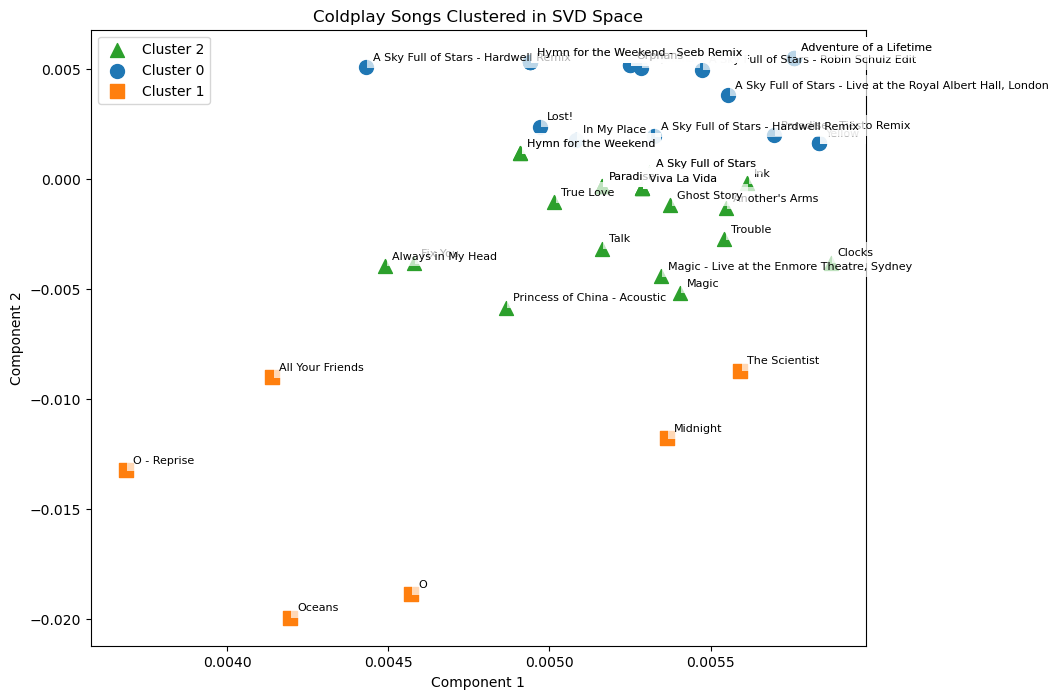

In [68]:
# 仅仅显示Coldplay的歌曲
# Convert to pandas for plotting
coldplay_matrix = df_merged.filter(F.col("track_artist") == "Coldplay") \
                          .select("track_name", "prediction", "svd_features") \
                          .toPandas()

# Extract the SVD components from features vector
coldplay_matrix["Component 1"] = coldplay_matrix["svd_features"].apply(lambda x: float(x[0]))
coldplay_matrix["Component 2"] = coldplay_matrix["svd_features"].apply(lambda x: float(x[1]))
from matplotlib import pyplot as plt
# Create scatter plot
plt.figure(figsize=(10, 8))

# Define markers for each cluster
markers = ['o', 's', '^']  # circle, square, triangle
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # distinct colors for each cluster

# Plot each cluster with different marker and color
for cluster in coldplay_matrix["prediction"].unique():
    mask = coldplay_matrix["prediction"] == cluster
    plt.scatter(coldplay_matrix[mask]["Component 1"],
               coldplay_matrix[mask]["Component 2"], 
               c=[colors[cluster]],
               marker=markers[cluster],
               label=f'Cluster {cluster}',
               s=100)  # increase marker size

# Add labels with adjustable positions to avoid overlap
for i, txt in enumerate(coldplay_matrix["track_name"]):
    x = coldplay_matrix["Component 1"].iloc[i]
    y = coldplay_matrix["Component 2"].iloc[i]
    plt.annotate(txt, (x, y),
                xytext=(5, 5),  # 5 points offset
                textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                fontsize=8)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Coldplay Songs Clustered in SVD Space")
plt.legend()
plt.show()

In [83]:
# Convert to pandas for analysis
cp_clusters = df_merged.filter(F.col("track_artist") == "Coldplay") \
                         .select("track_name", "track_artist", "prediction") \
                         .toPandas()
#print(album_clusters)
album_mapping=df.filter(F.col("track_artist") == "Coldplay").select("track_name",  "track_album_name").toPandas()
cp_clusters=cp_clusters.merge(album_mapping, on="track_name", how="left")
cp_clusters.groupby(["track_album_name", "prediction"]) \
           .count() \
           .reset_index() \
           .rename(columns={"count": "track_count"}) \
           .sort_values(by="track_album_name")
print(cp_clusters)

                              track_name track_artist  prediction  \
0                    A Sky Full of Stars     Coldplay           2   
1                    A Sky Full of Stars     Coldplay           2   
2                    A Sky Full of Stars     Coldplay           2   
3                                Orphans     Coldplay           0   
4                                Orphans     Coldplay           0   
..                                   ...          ...         ...   
91     Hymn for the Weekend - Seeb Remix     Coldplay           0   
92     Hymn for the Weekend - Seeb Remix     Coldplay           0   
93     Hymn for the Weekend - Seeb Remix     Coldplay           0   
94  A Sky Full of Stars - Hardwell Remix     Coldplay           0   
95  A Sky Full of Stars - Hardwell Remix     Coldplay           0   

                        track_album_name  
0                          Ghost Stories  
1                          Ghost Stories  
2                          Ghost Stories  

In [95]:
# Create a pivot table for the heatmap
heatmap_data = cp_clusters.groupby(["track_album_name", "prediction"]).size().unstack()
# 在每一个专辑内部计算比例
heatmap_data = heatmap_data.fillna(0)
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)
heatmap_data.to_csv("heatmap_data.csv")


That's all for now, but you're encouraged to dig further into the specific songs within each cluster to describe the logic of the clusters in more detail on your own!

In [15]:
import pandas as pd
# Show the V matrix (feature loadings for each component)
print("V matrix (feature loadings):")
print("Shape:", V.numRows, "x", V.numCols)

# Convert V matrix to numpy array and create DataFrame
V_array = V.toArray()
feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

# Create DataFrame with feature loadings
loadings_df = pd.DataFrame(V_array, index=feature_names, 
                          columns=[f'Component {i+1}' for i in range(V.numCols)])

# Sort features by absolute values for each component
for col in loadings_df.columns:
    loadings_df = loadings_df.sort_values(by=col, key=abs, ascending=False)
    print(f"\n{col} loadings:")
    print(loadings_df[col].round(3))


V matrix (feature loadings):
Shape: 12 x 2

Component 1 loadings:
energy              0.481
tempo               0.479
key                 0.411
duration_ms         0.402
mode               -0.237
valence             0.236
danceability        0.181
loudness            0.159
liveness            0.131
speechiness         0.114
acousticness        0.083
instrumentalness    0.040
Name: Component 1, dtype: float64

Component 2 loadings:
mode                0.582
key                 0.573
acousticness       -0.504
liveness            0.152
energy             -0.152
tempo               0.107
danceability       -0.102
duration_ms        -0.069
instrumentalness   -0.051
speechiness        -0.048
loudness           -0.033
valence             0.020
Name: Component 2, dtype: float64
